<h1>Исследовательский анализ для «Так закаляем сталь»<span class="tocSkip"></span></h1>


# Описание

Металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали, чтобы оптимизировать производственные расходы. Необходимо построить модель, которая предскажет температуру стали.

**Цель:** построить модель предсказания температуры стали, которая будет иметь среднюю абсолютную ошибку (MAE) не больше 6.8

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Расположение датасета в тренажере: **/datasets/final_steel/**

# Анализ

## Импортируем библиотеки и загрузим данные

In [1]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import  make_pipeline
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RepeatedKFold, KFold

import time

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

In [2]:
# !pip install pandas_profiling

In [3]:
from pandas_profiling import ProfileReport

In [4]:
try:
    data_arc = pd.read_csv('/Users/egorgerasenko/ПРОЕКТЫ ДЛЯ JUPITER NOTEBOOK LOCAL/final_steel/data_arc.csv',parse_dates=[1,2])
    data_bulk = pd.read_csv('/Users/egorgerasenko/ПРОЕКТЫ ДЛЯ JUPITER NOTEBOOK LOCAL/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/Users/egorgerasenko/ПРОЕКТЫ ДЛЯ JUPITER NOTEBOOK LOCAL/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/Users/egorgerasenko/ПРОЕКТЫ ДЛЯ JUPITER NOTEBOOK LOCAL/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/Users/egorgerasenko/ПРОЕКТЫ ДЛЯ JUPITER NOTEBOOK LOCAL/final_steel/data_temp.csv',parse_dates=[1])
    data_wire = pd.read_csv('/Users/egorgerasenko/ПРОЕКТЫ ДЛЯ JUPITER NOTEBOOK LOCAL/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/Users/egorgerasenko/ПРОЕКТЫ ДЛЯ JUPITER NOTEBOOK LOCAL/final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv',parse_dates=[1,2])
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv',parse_dates=[1])
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
    

## Знакомство с данными

Для первичного знакомства был использован ProfileReport. Чтобы визуально не перегружать ноутбук, этот метод оставим без вывода, но познакомимся с основными показателями отдельно и выведем графики, где необходимо сделать акцент

In [5]:
data_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]
for i in data_list:
    print('\033[1m' + 'ИНФО' + '\033[0m')
    print(i.info())
    print('\033[1m' + 'ПРОПУСКИ' + '\033[0m')
    print(i.isna().sum())
    print('*'*25)
    print('\033[1m' + 'ЦИФРОВОЕ ОПИСАНИЕ' + '\033[0m')
    print(i.describe())
    print('*'*25)

ИНФО
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None
ПРОПУСКИ
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
*************************
ЦИФРОВОЕ ОПИСАНИЕ
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502          

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
*************************
ЦИФРОВОЕ ОПИСАНИЕ
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000
*************************


### Данные об электродах 

In [6]:
# ProfileReport(data_arc)

Выведем ящик с усами, взглянуть на аномалию, а также посмотрим на распределение без нее

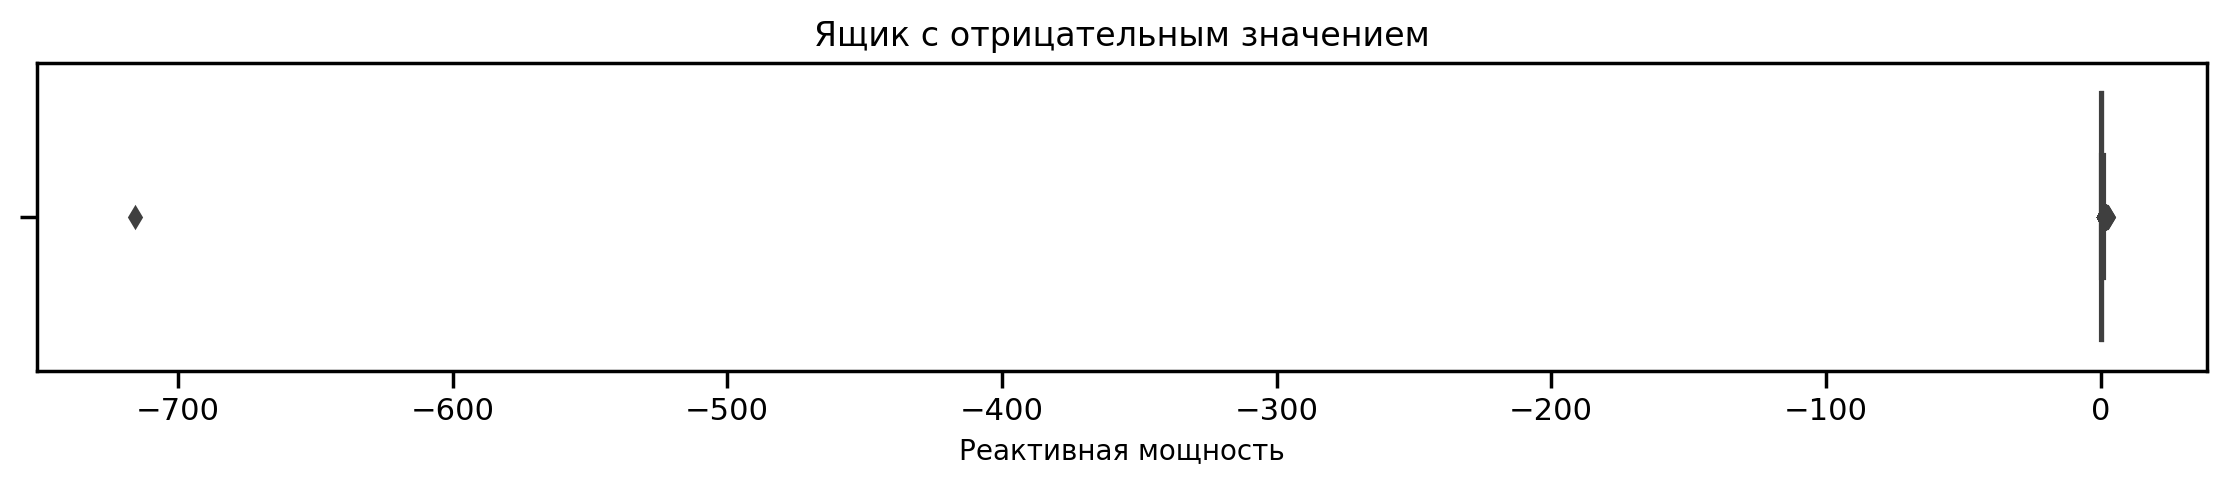

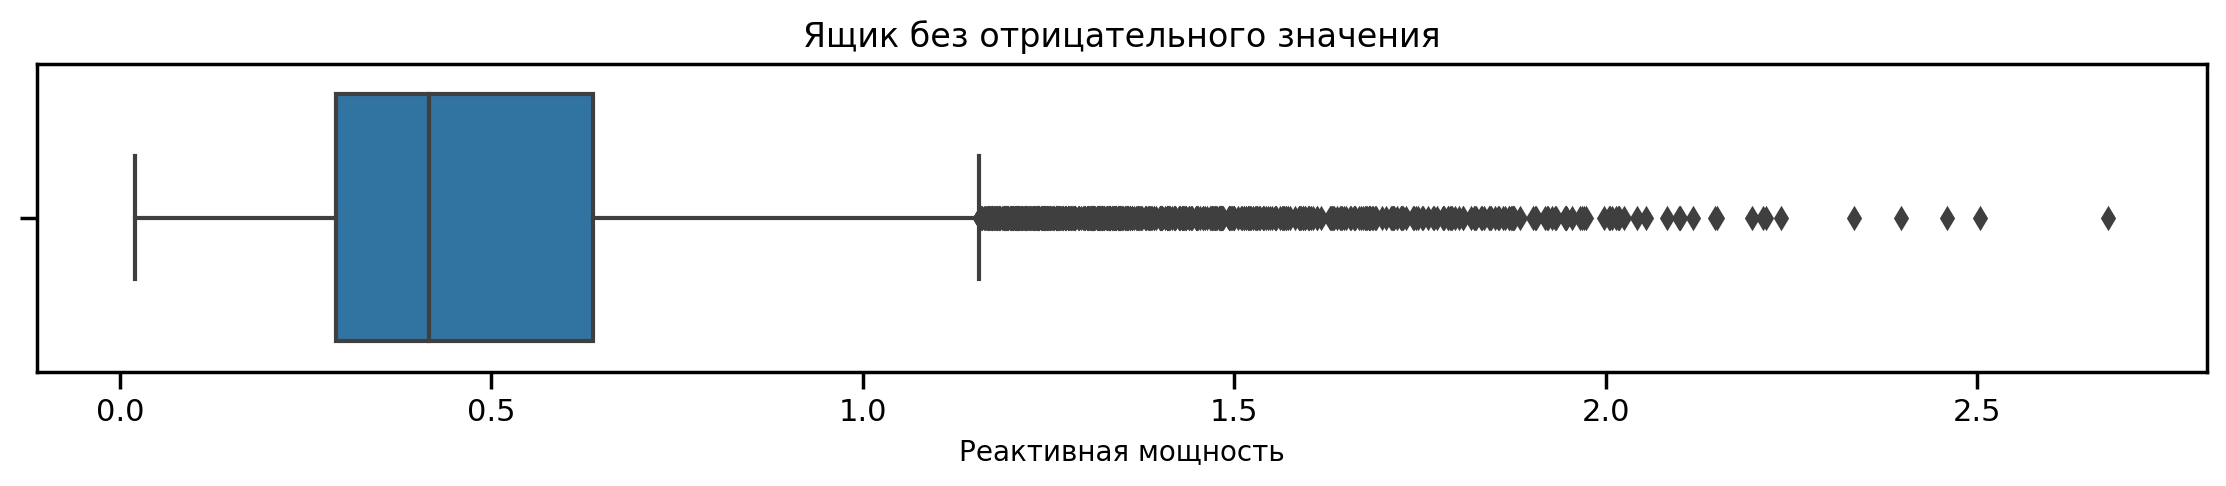

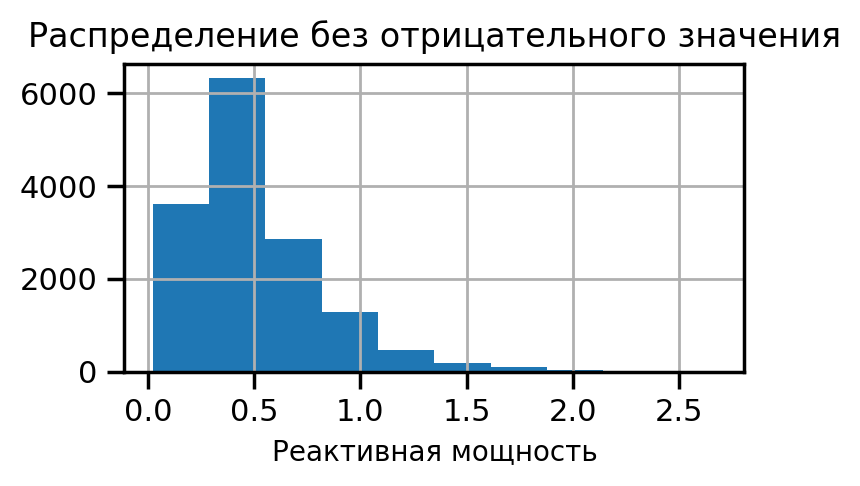

In [7]:
plt.figure(figsize=(14,2))
plt.title('Ящик с отрицательным значением',fontsize=12);
sns.boxplot(data=data_arc,x='Реактивная мощность');
plt.xlabel('Реактивная мощность', fontsize=10);
plt.show()
plt.figure(figsize=(14,2))
plt.title('Ящик без отрицательного значения',fontsize=12);
df_arc_temp = data_arc[data_arc['Реактивная мощность']>0]
sns.boxplot(data=df_arc_temp,x='Реактивная мощность');
plt.xlabel('Реактивная мощность', fontsize=10);
plt.show()
plt.figure(figsize=(4,2))
df_arc_temp['Реактивная мощность'].hist();
plt.title('Распределение без отрицательного значения',fontsize=12);
plt.xlabel('Реактивная мощность', fontsize=10);
plt.show()

### Данные о подаче сыпучих материалов (объём)

У нескольких столбцов наблюдается высокая корреляцию. Продемонстрируем ее на графике

In [8]:
# ProfileReport(data_bulk)

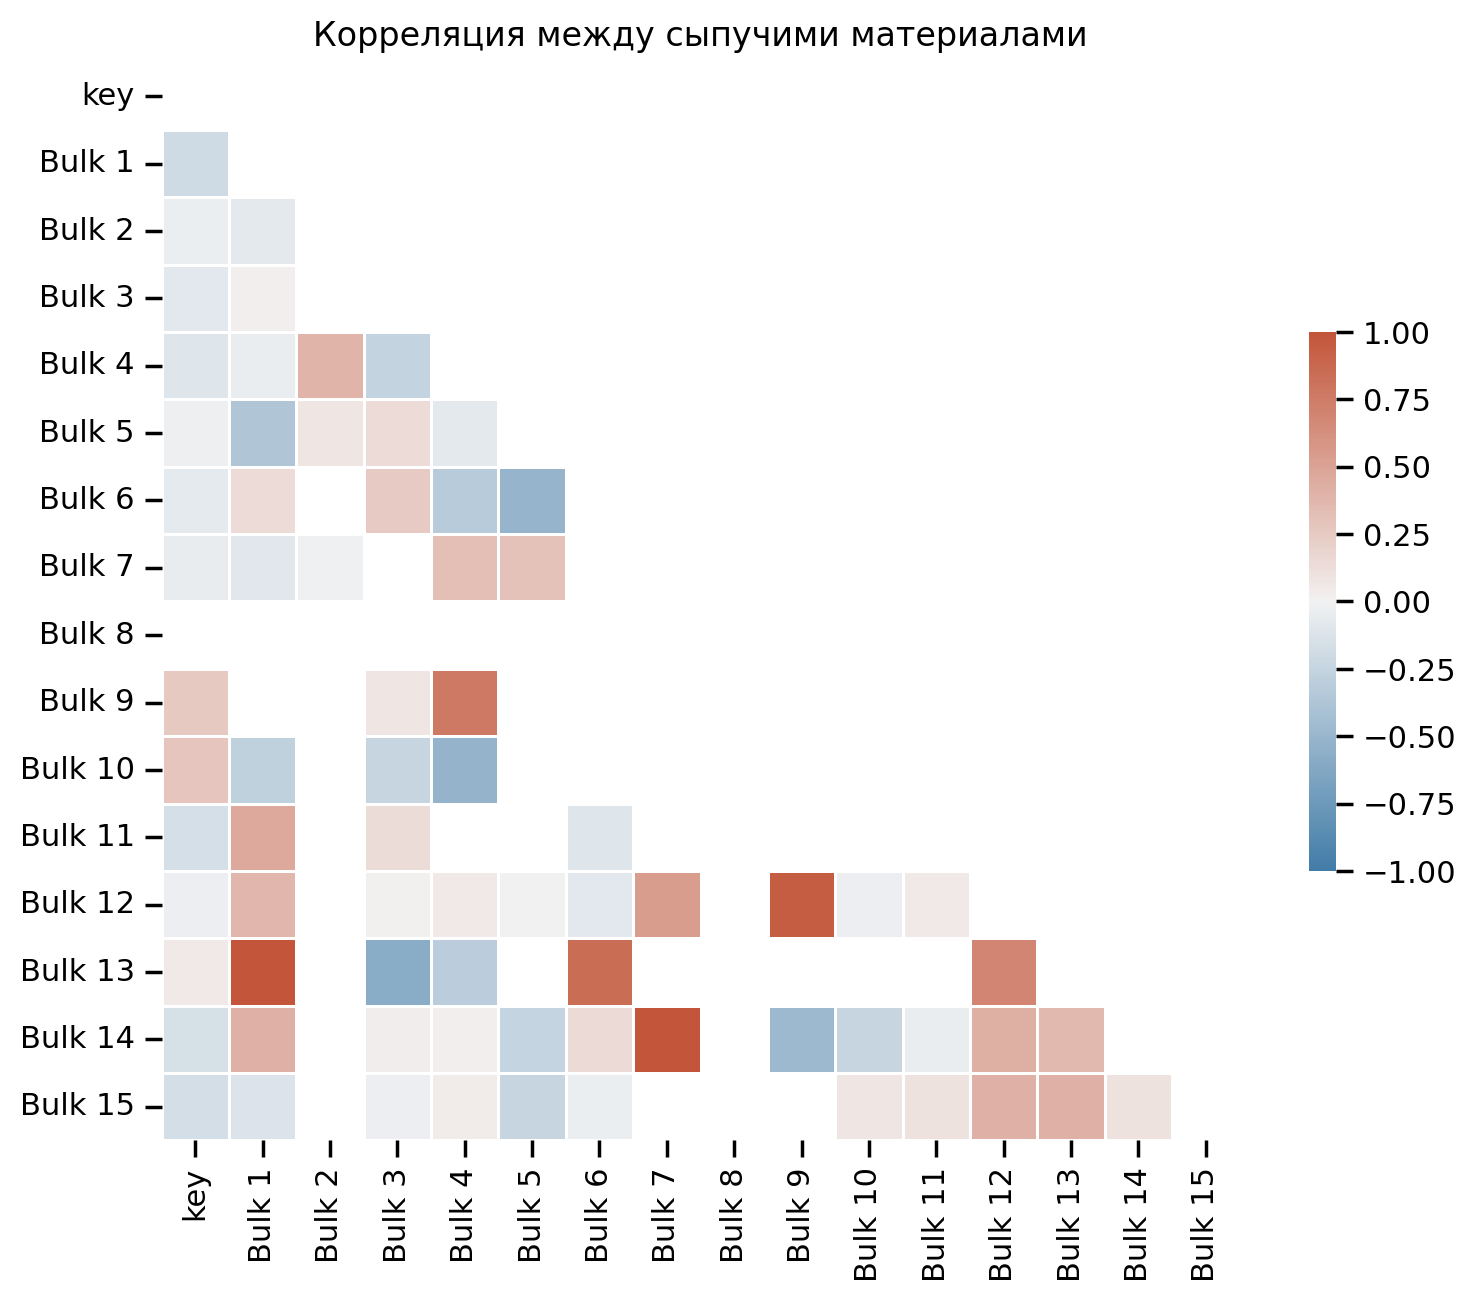

In [9]:
corr = data_bulk.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 7))
plt.title('Корреляция между сыпучими материалами',fontsize=12);
cmap = sns.diverging_palette(240, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.4, cbar_kws={"shrink": .5});

### Данные о подаче сыпучих материалов (время)

In [10]:
# ProfileReport(data_bulk_time)

### Данные о продувке сплава газом

In [11]:
# ProfileReport(data_gas)

Выведем график ящик с усами для визуализации выбросов. 95-ому процентилю соответствует значение 22.6. График показывает аномальные значения, но заказчик подтвердил, что цифры настоящие

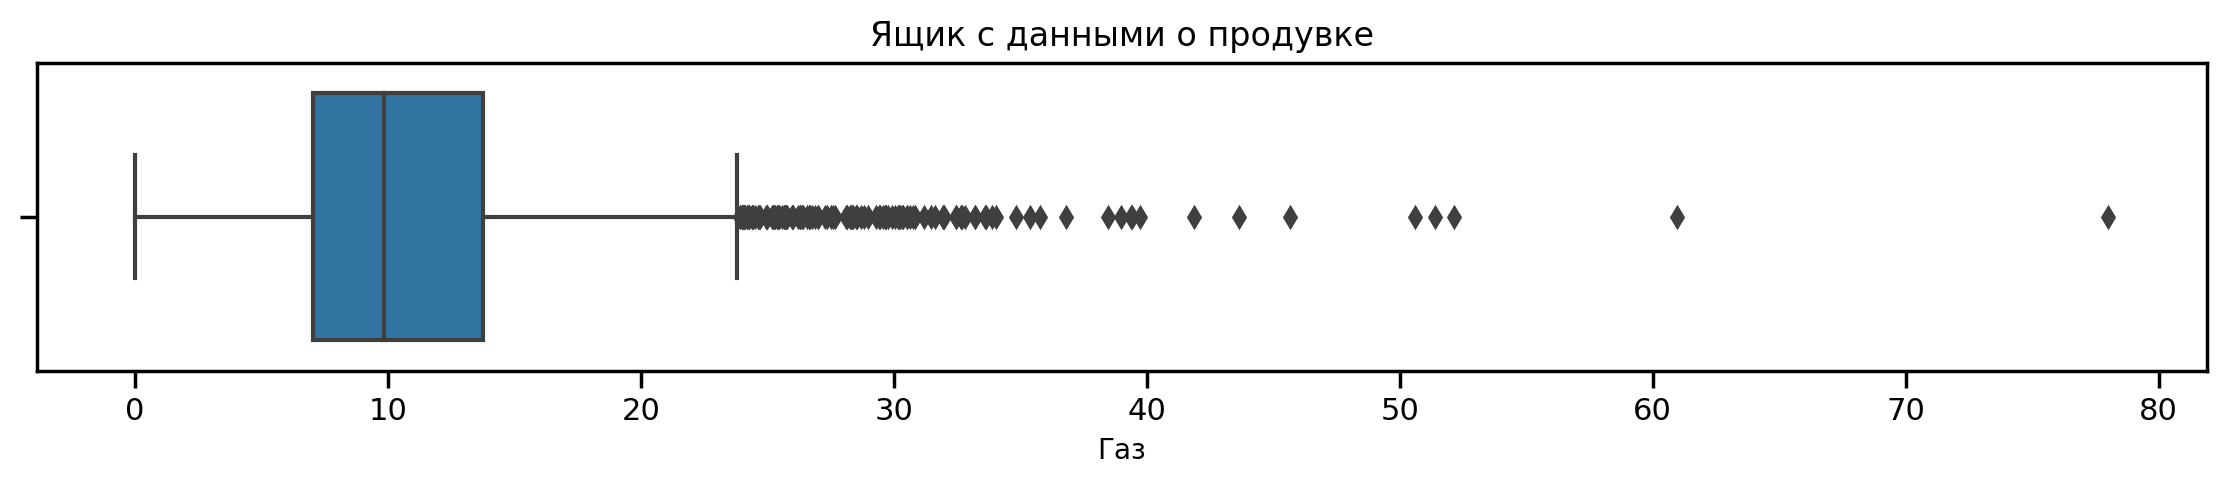

In [12]:
plt.figure(figsize=(14,2))
plt.title('Ящик с данными о продувке',fontsize=12);
sns.boxplot(data=data_gas,x='Газ 1');
plt.xlabel('Газ', fontsize=10);
plt.show()

### Результаты измерения температуры

In [13]:
# ProfileReport(data_temp)

Выведем график ящик с усами. Выяснили, что сталь плавится от 1400 градусов, значит значения ниже этой отметки, следует отсечь

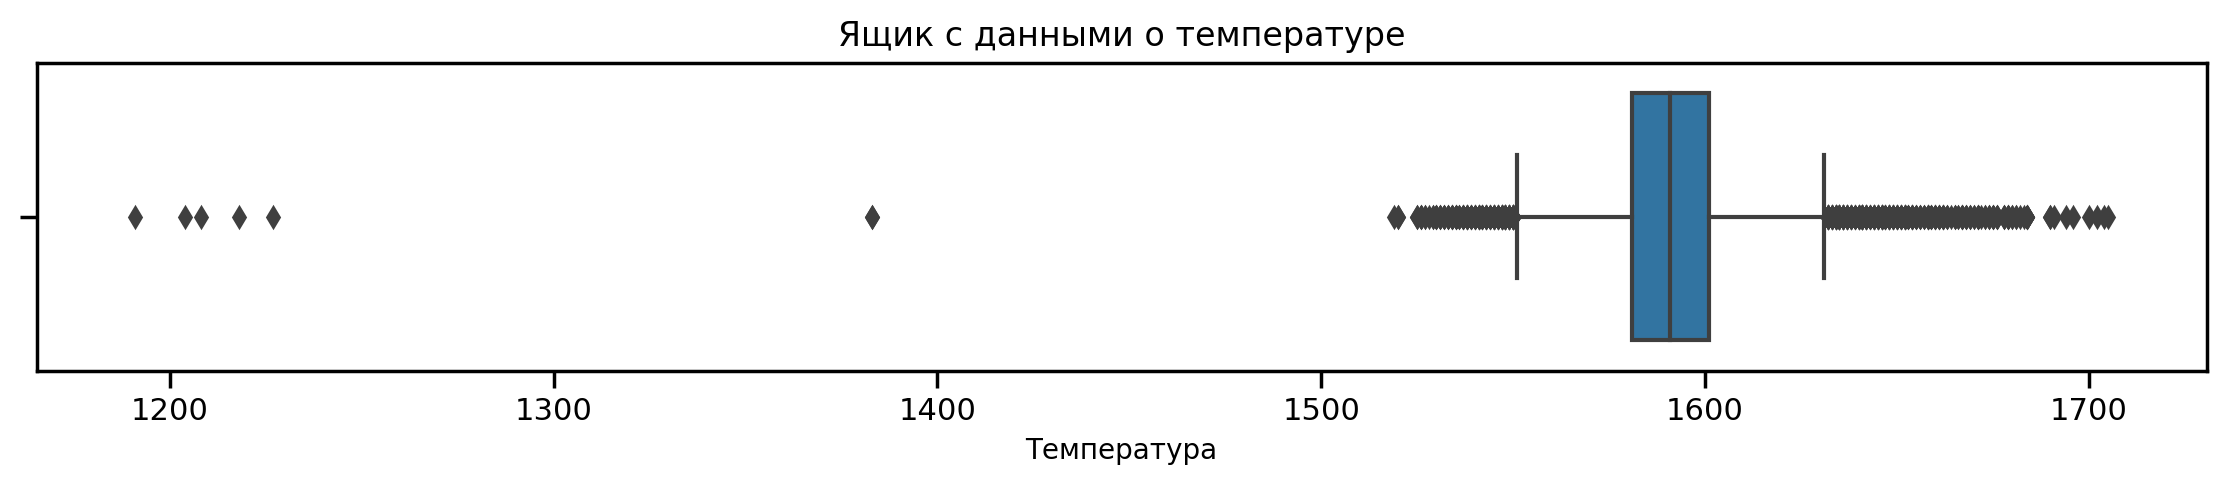

In [14]:
plt.figure(figsize=(14,2))
plt.title('Ящик с данными о температуре',fontsize=12);
sns.boxplot(data=data_temp,x='Температура');
plt.xlabel('Температура', fontsize=10);
plt.show()

In [15]:
print('Пропусков в столбце Температура:', ((data_temp['Температура'].isna().sum()/len(data_temp))*100).round(2),'%')

Пропусков в столбце Температура: 18.24 %


Дополнительно приглядимся к пропускам

In [16]:
data_temp[data_temp['key']==2500]

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN


**На партии 2500 2019-08-06 после итерации в 03:11:31 значения температуры отсутствуют**

Изучим есть ли закономерность выбросов - сравним по ключу аномалии газа, температуры и мощности.

In [17]:
gas = data_gas[data_gas['Газ 1'] > 40]
gas

,key,Газ 1
116,117,50.581035
277,280,60.935689
319,322,77.995040
660,663,41.854643
1461,1464,43.655411
2105,2108,45.638999
2107,2110,52.142373
2567,2570,51.380229


In [18]:
arc = data_arc[data_arc['Реактивная мощность']> 2.2]
arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
2661,580,2019-05-24 18:06:25,2019-05-24 18:18:29,2.940772,2.211983
2939,640,2019-05-27 01:25:40,2019-05-27 01:38:06,2.766592,2.236813
7799,1689,2019-07-02 18:49:03,2019-07-02 19:04:10,3.731596,2.676388
9226,2001,2019-07-19 20:19:15,2019-07-19 20:31:16,3.156276,2.504206
9361,2029,2019-07-20 20:19:38,2019-07-20 20:28:44,2.019395,2.459959
12424,2701,2019-08-13 06:11:16,2019-08-13 06:25:02,3.150762,2.397032
13760,2985,2019-08-23 19:03:07,2019-08-23 19:14:14,2.779279,2.335088
14200,3086,2019-08-27 03:41:09,2019-08-27 03:53:10,3.052813,2.216230


In [19]:
temp = data_temp[data_temp['Температура']>1690]
temp


,key,Время замера,Температура
1794,330,2019-05-15 17:29:26,1704.0
1795,330,2019-05-15 17:30:51,1705.0
1796,330,2019-05-15 17:31:51,1700.0
8903,1817,2019-07-06 23:44:44,1691.0
8904,1817,2019-07-06 23:47:28,1702.0
8905,1817,2019-07-06 23:48:03,1694.0
8906,1817,2019-07-06 23:48:48,1696.0


In [20]:
for i in temp['key']:
    if i in arc['key']:
        print(i)
    elif i in gas['key']:
        print(i)
else:
    print('Закономерности не выявлено, в датасетах с аномалиями ключи партий отличаются')
    

Закономерности не выявлено, в датасетах с аномалиями ключи партий отличаются


### Данные о проволочных материалах (объём)

In [21]:
# ProfileReport(data_wire)

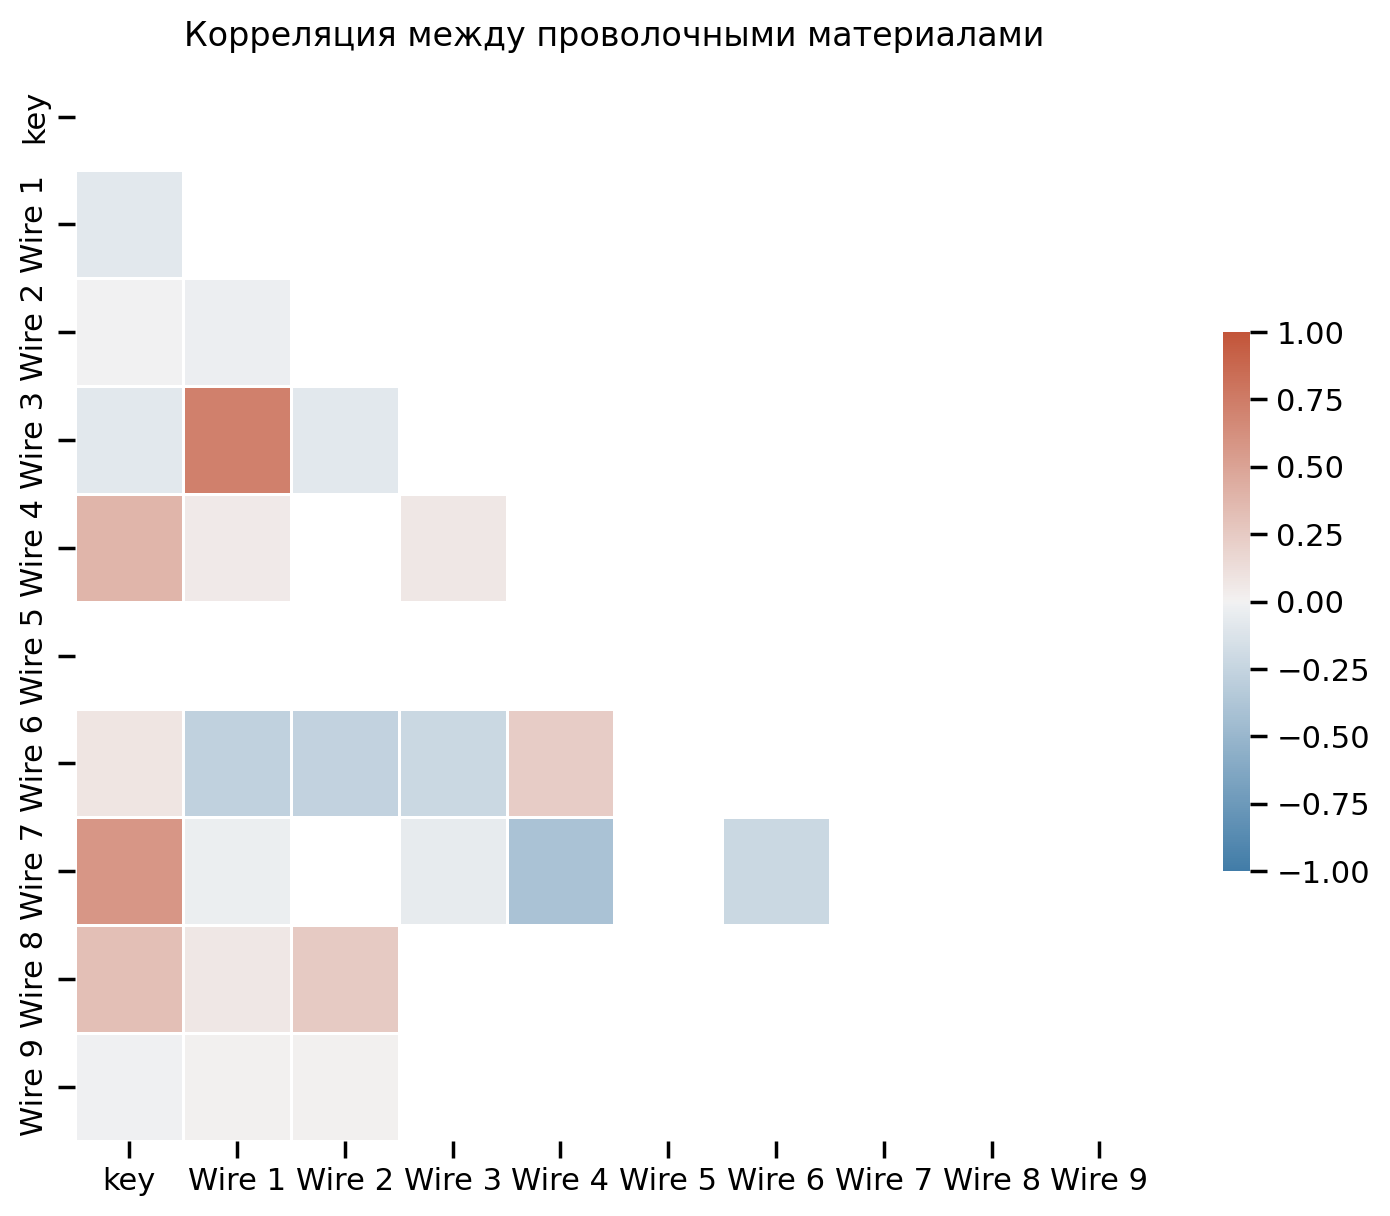

In [22]:
corr = data_wire.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 7))
plt.title('Корреляция между проволочными материалами',fontsize=12);
cmap = sns.diverging_palette(240, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.4, cbar_kws={"shrink": .5});

### Данные о проволочных материалах (время)

In [23]:
# ProfileReport(data_wire_time)

## Выводы

Встречается неверный тип данных, высокая корреляция между данными, пропуски. Подробнее:

- **data_arc** - 2 и 3 столбцы неверный тип данный, необходимо привести к datetime, а в реактивной мощности есть одно отрицательное значение, наверное опечатка.
- **data_bulk** - 71.5% пропусков. Высокая корреляция между столбцами.
- **data_bulk_time** - 71.5% пропусков. Вместо значений даты, ошибочный тип object
- **data_gas** - нет пропусков, верный тип данных, график распределения стремится к нормальному, есть аномальные значения Газа
- **data_temp** - неверный тип данный у столбца 2 (время замера), также обнаружено 18% пропусков значений Температуры - ее перестали вносить на партии 2500. Так как температура плавления стали не может быть ниже 1350 градусов (для отлички) и 1400 градусов (для конструкционной), то значения ниже этого значения являются ошибочными. 
- **data_wire** - пропуски 75,9%. Обнаружена слабая корреляция между столбцами, похожая ситуация с данными подачи сыпучих материалов
- **data_wire_time** - 75,9% пропусков. Вместо значений даты, ошибочный тип object

# План работы

**Предобработка:**
- Убрать значения температуры ниже 1400 градусов, причем всю партию. В столбце "Температура" данные заканчивают вносить после 2019-08-06, 03:11:31, удалим пропуски после этой даты. Также удалим партии, в которых нет температуры с финальным замером.
- Объединить датасеты с электродами, измерением температуры и продувке газом в единую таблицу. Не используем датасеты о подаче сыпучих и проволочных материалов в связи с огромными пропусками, к тому же необходимые процедуры, количество итераций и время у нас имеется в других датасета.
- Привести к необходимым типам данных: вместо object к datetime
- Сгруппировать по ключу партии датасеты, после создания новых признаков. 


**Новые признаки**. 
- Вычислим **Полную мощность**, заменив этим столбцом Активную и Реактивную мощности - учитывая их высокую корреляцию, это будет мешать при обучении на моделе LinearRegression. Полная мощность – это геометрически вычисляемая величина, равная корню из суммы квадратов активной и реактивной мощностей соответственно.
- Вычислим **Количество потребленной энергии**. Для этого мощность умножим на время работы. 


**Обучение и выводы:**
- Будем применять стандартизацию, так как все признаки важны, нельзя чтоб машина подумала что если разброс значений где-то выше, то и признак значимей.
- Разделим выборки на обучающую (75%) и тестовую (25%). Оценку модели будем выбирать с помощью кросс-валидации
- Целевым признаком является последняя замеренная температура. В качестве признака при обучении можно использовать начальную температуру
- Зафиксируем random_state = 13022023
- Будем обучать на нескольких моделях, минимум двух: LinearRegression, LGBMRegressor. Возможно будут использованы какие-либо ещё
- В качестве метрики используем MAE - среднюю абсолютную ошибку. Она поможет оценить насколько наш прогноз расходится с реальным числом
- Проверим адеватность модели на константной
- Лучшую модель проверим на тестовой выборке
- Напишем вывод, сверим ход проекта с изначальным планом

# Цель

Построить модель предсказания температуры стали, которая будет иметь среднюю абсолютную ошибку (MAE) не больше 6.8

# Предобработка

## Температура и новые признаки

**Согласно плану работ:**
- удалим партии, в которых была зафиксирована температура ниже 1400 градусов
- удалим партии, в которых нет температуры с финальным замером
- удалим промежуточные замеры температуры
- сделаем новый признак - количество нагревов

Добавим в отдельный список номера партий, в которых в одной из итераций были аномально низкие температуры - ниже 1400 градусов

In [24]:
key_1400 = data_temp[data_temp['Температура']<1400]['key']
print('Найдено', key_1400.shape[0], 'партий')

Найдено 7 партий


Удалим из датасета те номера партий, которые входят в созданный нами список

In [25]:
data_temp_temp = data_temp.drop(data_temp[data_temp['key'].isin(key_1400)].index).reset_index(drop=True)
print('Удалено',(data_temp.shape[0] - data_temp_temp.shape[0]),'строк')

Удалено 50 строк


Удалим партии, в которых нет температуры финальной итерации - наш таргет - и остальные пропуски

In [26]:
key_nan = data_temp_temp[data_temp_temp['Температура'].isna()]['key'].unique()
key_nan.shape[0]

738

In [27]:
df_temp_final = data_temp_temp.drop(data_temp_temp[data_temp_temp['key'].isin(key_nan)].index).reset_index(drop=True)
print('Удалено',(data_temp_temp.shape[0] - df_temp_final.shape[0]),'строки')

Удалено 3634 строки


In [28]:
df_temp_final.tail(10)

,key,Время замера,Температура
12213,2497,2019-08-06 01:41:53,1571.0
12214,2497,2019-08-06 01:53:50,1589.0
12215,2498,2019-08-06 02:03:49,1591.0
12216,2498,2019-08-06 02:04:21,1570.0
12217,2498,2019-08-06 02:12:00,1580.0
12218,2498,2019-08-06 02:19:26,1593.0
12219,2498,2019-08-06 02:25:31,1594.0
12220,2499,2019-08-06 02:40:25,1569.0
12221,2499,2019-08-06 02:54:24,1604.0
12222,2499,2019-08-06 03:00:28,1603.0


Удалим строки с промежуточными замерами температуры, с помощью группировки по ключу партии и агрегации. Температуру аггрегируем по первому и последнему значению, и дополнительно выведем новый признак - количество замеров через count

In [29]:
agg_func_temp = {'Температура': ['first', 'last'],
                'Время замера': ['count']}
df_temp_final = df_temp_final.groupby(by ='key').agg(agg_func_temp).reset_index()
df_temp_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (key, )                2472 non-null   int64  
 1   (Температура, first)   2472 non-null   float64
 2   (Температура, last)    2472 non-null   float64
 3   (Время замера, count)  2472 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 77.4 KB


In [30]:
df_temp_final.columns = ['key','Температура начальная','Температура конечная','Количество замеров']

In [31]:
df_temp_final.head(10)

,key,Температура начальная,Температура конечная,Количество замеров
0,1,1571.0,1613.0,5
1,2,1581.0,1602.0,6
2,3,1596.0,1599.0,5
3,4,1601.0,1625.0,3
4,5,1576.0,1602.0,2
5,6,1543.0,1596.0,5
6,7,1586.0,1599.0,5
7,8,1577.0,1598.0,4
8,9,1587.0,1592.0,5
9,10,1574.0,1593.0,8


После группировки и агрегации проверим признаки на корреляцию

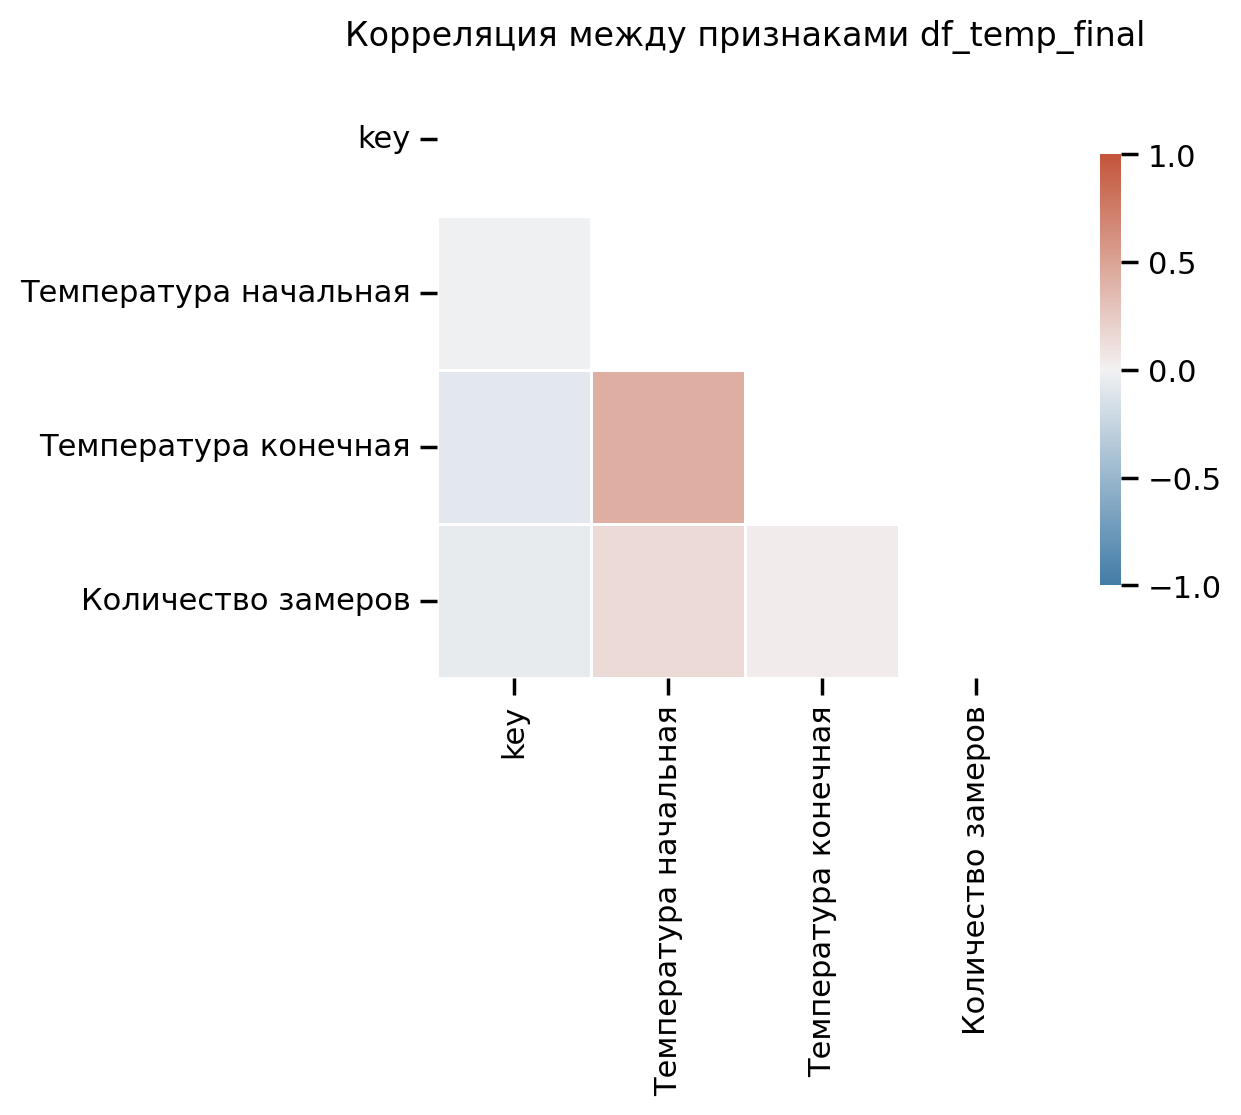

In [32]:
corr = df_temp_final.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(6, 4))
plt.title('Корреляция между признаками df_temp_final',fontsize=12);
cmap = sns.diverging_palette(240, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.4, cbar_kws={"shrink": .7});

Есть слабая корреляция между начальной и конечно температуры, но они будут разнесены между признаком и целевым признаком. Значит можем оставить столбцы, они не повлияют на переобучение модели

## Новые признаки

Создадим новые признаки и агрегируем по номеру партии:
- Время нагрева - он понадобится нам для подсчета Энергии
- Полная мощность - тоже понадобится нам для подсчета Энергии, к тому же Активная и Реактивная мощности коррелируют между собой
- Агрегируем по столбцу с партиями
- Избавимся от лишних столбцов

In [33]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Время нагрева в секундах получаем из разницы значений столбцов Конец нагрева и Начало нагрева

In [34]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


В связи с высокой корреляцией *Активной и Реактивной мощности*, выводим новый признак *Полная мощность* по формуле: 

$ S= \sqrt{(P^2 + Q^2)} $


In [35]:
data_arc['Полная мощность'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239


Теперь из новых столбцов *Время* и *Полная мощность* мы можем посчитать Энергию по формуле:

$W = P*t$

In [36]:
data_arc['Энергия'] = (data_arc['Время нагрева'] * data_arc['Полная мощность']).round(2)

In [37]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность,Энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639,272.15
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010,177.42
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038,154.12
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470,719.22
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239,119.47


Группируем по номеру партии, в качестве агрегирующей функции используем сумму значений

In [38]:
data_arc = data_arc.groupby(by ='key').sum().reset_index()
data_arc.head()

,key,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность,Энергия
0,1,4.878147,3.183241,1098,5.826395,1442.38
1,2,3.052598,1.998112,811,3.649216,881.23
2,3,2.525882,1.599076,655,2.989534,525.07
3,4,3.209250,2.060298,741,3.814962,796.92
4,5,3.347173,2.252643,869,4.035758,1199.13


Убираем лишние столбцы

In [39]:
data_arc.drop(data_arc.columns[[1, 2]], axis=1, inplace= True)
data_arc.head()

,key,Время нагрева,Полная мощность,Энергия
0,1,1098,5.826395,1442.38
1,2,811,3.649216,881.23
2,3,655,2.989534,525.07
3,4,741,3.814962,796.92
4,5,869,4.035758,1199.13


Взглянем на корреляцию между новыми признаками

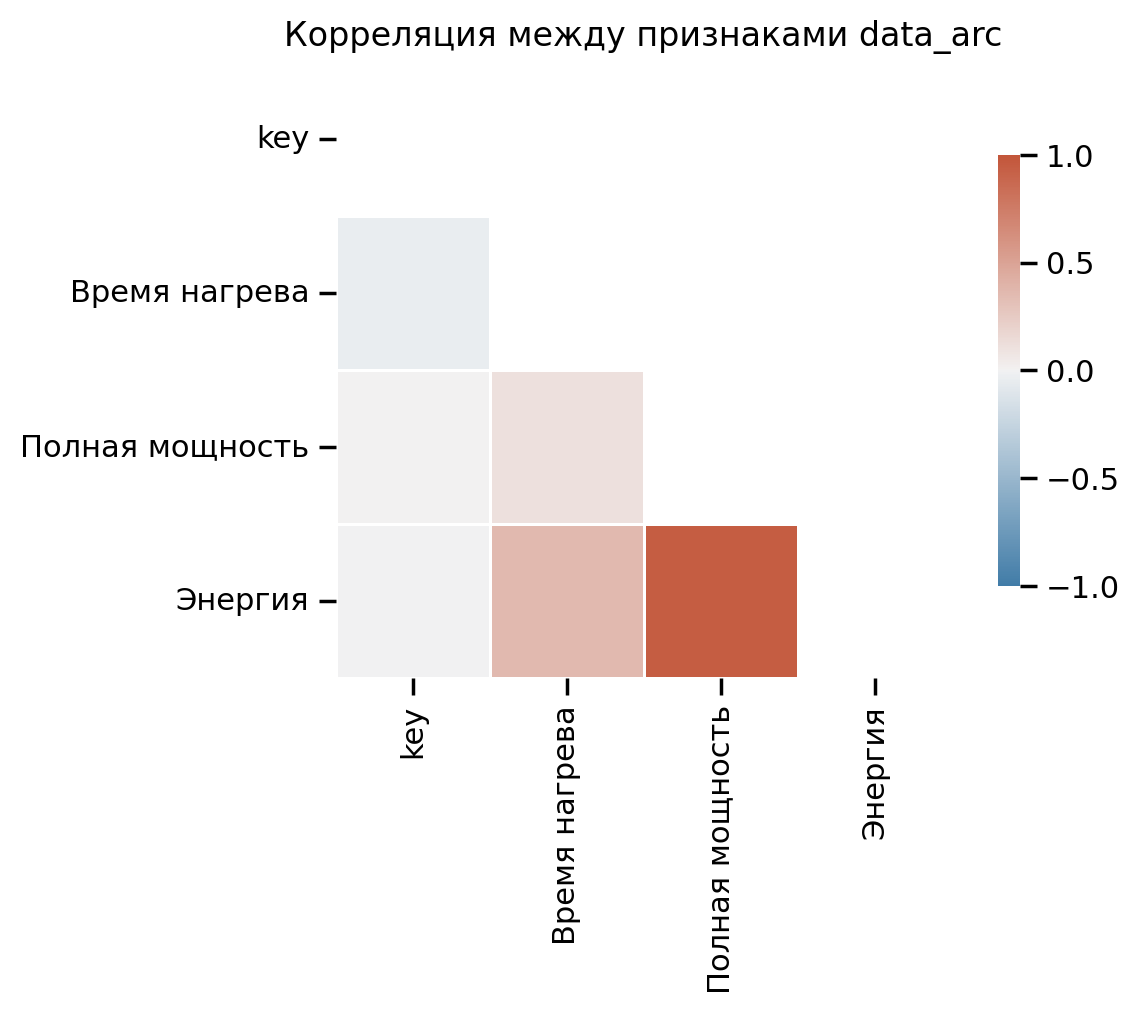

In [40]:
corr = data_arc.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(6, 4))
plt.title('Корреляция между признаками data_arc',fontsize=12);
cmap = sns.diverging_palette(240, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.4, cbar_kws={"shrink": .7});

Ожидаемо, *Энергия* коррелирует с признаками, из которых мы вывели данный признак. Оставим *Энергию*, уберем *Полную мощность*

In [41]:
data_arc.drop(data_arc.columns[[2]], axis=1, inplace= True)

In [42]:
data_arc

,key,Время нагрева,Энергия
0,1,1098,1442.38
1,2,811,881.23
2,3,655,525.07
3,4,741,796.92
4,5,869,1199.13
...,...,...,...
3209,3237,909,958.33
3210,3238,546,555.86
3211,3239,1216,1013.07
3212,3240,839,729.21


## Подача сыпучих

Заполняем пропуски нулями и удаляем столбцы с высокой корреляцией

In [43]:
data_bulk.fillna(0, inplace=True)

In [44]:
data_bulk = data_bulk.drop(['Bulk 7','Bulk 9','Bulk 13'], axis=1)
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0


## Подача проволочных

Заполняем пропуски нулями и удаляем столбцы с высокой корреляцией

In [45]:
data_wire.fillna(0, inplace=True)

In [46]:
data_wire = data_wire.drop(['Wire 3'], axis=1)
data_wire.head()

,key,Wire 1,Wire 2,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


## Объединение датасетов

Нужные датасеты сгруппированы по номерам партий: data_gas, data_arc, df_temp_final, data_bulk и data_wire.
Так как важны партии, в которые воли все процессы, то присоединять будем по внутреннему пересечению - партии, которые есть во всех датасетах.

In [47]:
df = (df_temp_final.merge(data_arc,
                          how='inner', 
                          on='key').merge(data_gas, 
                                          how='inner',
                                          on='key').merge(data_bulk, 
                                                          how='inner', 
                                                          on='key').merge(data_wire, 
                                                                          how='inner', 
                                                                          on='key'))

In [48]:
df

,key,Температура начальная,Температура конечная,Количество замеров,Время нагрева,Энергия,Газ 1,Bulk 1,Bulk 2,Bulk 3,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,5,1098,1442.38,29.749986,0.0,0.0,0.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,6,811,881.23,12.555561,0.0,0.0,0.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,5,655,525.07,28.554793,0.0,0.0,0.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,3,741,796.92,18.841219,0.0,0.0,0.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,2,869,1199.13,5.413692,0.0,0.0,0.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,3,723,778.82,7.125735,0.0,0.0,21.0,...,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2321,2496,1554.0,1591.0,4,940,875.26,9.412616,0.0,0.0,0.0,...,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2322,2497,1571.0,1589.0,2,569,556.94,6.271699,0.0,0.0,0.0,...,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2323,2498,1591.0,1594.0,5,750,767.82,14.953657,0.0,0.0,90.0,...,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
df.isna().sum()

key                      0
Температура начальная    0
Температура конечная     0
Количество замеров       0
Время нагрева            0
Энергия                  0
Газ 1                    0
Bulk 1                   0
Bulk 2                   0
Bulk 3                   0
Bulk 4                   0
Bulk 5                   0
Bulk 6                   0
Bulk 8                   0
Bulk 10                  0
Bulk 11                  0
Bulk 12                  0
Bulk 14                  0
Bulk 15                  0
Wire 1                   0
Wire 2                   0
Wire 4                   0
Wire 5                   0
Wire 6                   0
Wire 7                   0
Wire 8                   0
Wire 9                   0
dtype: int64

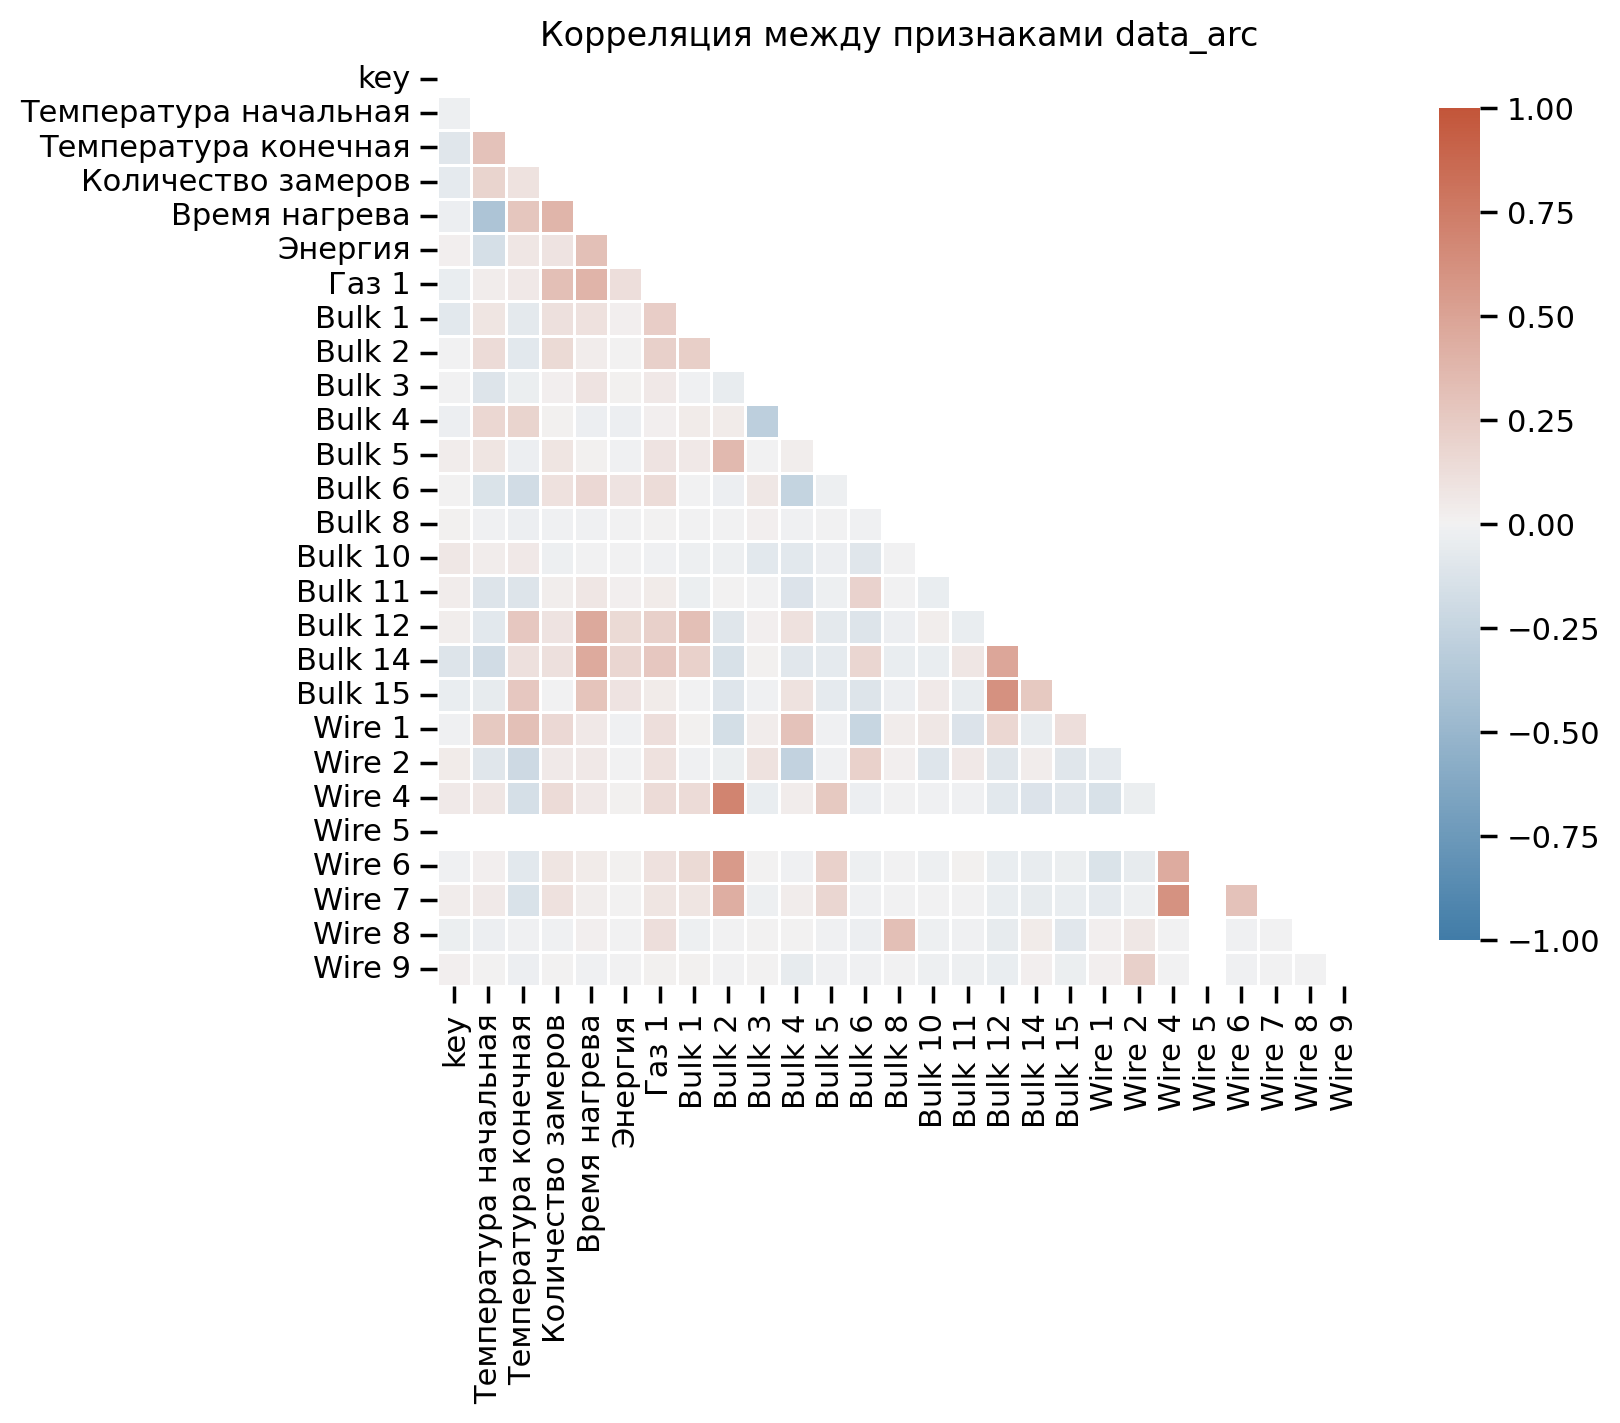

In [50]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 6))
plt.title('Корреляция между признаками data_arc',fontsize=12);
cmap = sns.diverging_palette(240, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.4, cbar_kws={"shrink": .9});

Некоторые столбцы имеют корреляцию с умеренной связью. Для обучения на Линейной регрессии исключим эти столбцы из выборки. 

Переименуем столбцы с русского в английский язык для удобства в последующей работе с моделями обучения


In [51]:
df.columns

Index(['key', 'Температура начальная', 'Температура конечная',
       'Количество замеров', 'Время нагрева', 'Энергия', 'Газ 1', 'Bulk 1',
       'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 8', 'Bulk 10',
       'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2',
       'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [52]:
df = df.rename(columns={'Температура начальная': 'temp_1',
                        'Температура конечная': 'temp_2',
                        'Количество замеров':'warm_count',
                        'Время нагрева': 'time',
                        'Энергия':'energy',
                        'Газ 1': 'gas'})

In [53]:
df.columns

Index(['key', 'temp_1', 'temp_2', 'warm_count', 'time', 'energy', 'gas',
       'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 8',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Wire 1',
       'Wire 2', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

# Обучение

In [54]:
#random_state
R = 13022023

## Разделение выборок

Столбцы, которые имеют среднюю связь корреляции удалим при создании признаков для Линейной регрессии так как для этой модели это может быть критично. В выборки для других моделей пойдет датасет без удаления этиз столбцов.

In [55]:
features = df.drop(['temp_2','key'], axis=1)
target = df['temp_2']

In [56]:
features_lr = df.drop(['temp_2', 'key','Bulk 14','Bulk 15','Bulk 12','Wire 6','Wire 7','Wire 4'], axis=1)
target_lr = df['temp_2']

In [57]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=R)

In [58]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(
    features_lr, target_lr, test_size=.25, random_state=R)

In [59]:
features_train.shape,features_test.shape,target_train.shape,target_test.shape

((1743, 25), (582, 25), (1743,), (582,))

In [60]:
features_train_lr.shape,features_test_lr.shape,target_train_lr.shape,target_test_lr.shape

((1743, 19), (582, 19), (1743,), (582,))

In [61]:
features_train.head(1)

,temp_1,warm_count,time,energy,gas,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2300,1583.0,3,354,361.65,9.92593,0.0,0.0,23.0,0.0,0.0,...,119.0,205.0,78.012482,55.011837,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
features_train_lr.head(1)

,temp_1,warm_count,time,energy,gas,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 8,Bulk 10,Bulk 11,Wire 1,Wire 2,Wire 5,Wire 8,Wire 9
2300,1583.0,3,354,361.65,9.92593,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,64.0,78.012482,55.011837,0.0,0.0,0.0


## Обучение моделей: DecisionTreeRegressor, LinearRegression и LGBMRegressor

In [63]:
model_DTR = make_pipeline(DecisionTreeRegressor(random_state=R))
model_LR = make_pipeline(StandardScaler(), LinearRegression())
model_LGBM = LGBMRegressor(objective="regression", random_state=R)

In [64]:
params_DT= {"decisiontreeregressor__max_depth":range(2, 10)}
params_LR = {'linearregression__fit_intercept':[True,False],
            'linearregression__normalize':[True,False]}
param_LGBM = {"n_estimators" : range(10,500,50) ,
              "max_depth": range(2,8,2)
             }

In [65]:
cv = RepeatedKFold(n_splits=5, n_repeats=15, random_state=R)

In [66]:
grid_DT = GridSearchCV(model_DTR,param_grid = params_DT,scoring='neg_mean_absolute_error', cv = cv)
grid_LR = GridSearchCV(model_LR,param_grid = params_LR,scoring='neg_mean_absolute_error', cv = cv)
grid_LGBM = GridSearchCV(model_LGBM, param_LGBM, scoring='neg_mean_absolute_error', cv=cv)

In [67]:
%%time
grid_DT.fit(features_train,target_train)

CPU times: user 7.33 s, sys: 40 ms, total: 7.37 s
Wall time: 7.41 s


GridSearchCV(cv=RepeatedKFold(n_repeats=15, n_splits=5, random_state=13022023),
             estimator=Pipeline(steps=[('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=13022023))]),
             param_grid={'decisiontreeregressor__max_depth': range(2, 10)},
             scoring='neg_mean_absolute_error')

In [68]:
%%time
grid_LR.fit(features_train_lr,target_train_lr)

CPU times: user 5.99 s, sys: 124 ms, total: 6.11 s
Wall time: 3.16 s


GridSearchCV(cv=RepeatedKFold(n_repeats=15, n_splits=5, random_state=13022023),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'linearregression__normalize': [True, False]},
             scoring='neg_mean_absolute_error')

In [69]:
%%time

grid_LGBM.fit(features_train, target_train)

CPU times: user 15min 30s, sys: 28.8 s, total: 15min 59s
Wall time: 4min 21s


GridSearchCV(cv=RepeatedKFold(n_repeats=15, n_splits=5, random_state=13022023),
             estimator=LGBMRegressor(objective='regression',
                                     random_state=13022023),
             param_grid={'max_depth': range(2, 8, 2),
                         'n_estimators': range(10, 500, 50)},
             scoring='neg_mean_absolute_error')

In [70]:
predict_DT = grid_DT.predict(features_train)
MAE_DT = mean_absolute_error(target_train, predict_DT)
print('MAE для дерева на кросс-валидации:', MAE_DT)

MAE для дерева на кросс-валидации: 6.016460573889512


In [71]:
predict_LR = grid_LR.predict(features_train_lr)
MAE_LR = mean_absolute_error(target_train_lr, predict_LR)
print('MAE для линейной на кросс-валидации:', MAE_LR)

MAE для линейной на кросс-валидации: 6.25515612858483


In [72]:
predict_LGBM = grid_LGBM.predict(features_train)
MAE_LGBM = mean_absolute_error(target_train, predict_LGBM)
print('MAE для LGBM на кросс-валидации:', MAE_LGBM)

MAE для LGBM на кросс-валидации: 5.232441851619027


In [73]:
grid_LGBM.best_params_

{'max_depth': 2, 'n_estimators': 210}

## Проверка модели на адекватность с помощью константной модели

Посмотрим на метрику, которую даст константная модель, чтобы оценить качество модели машинного обучения

In [74]:
dummy_regr = DummyRegressor()
dummy_regr.fit(features_train, target_train)
predict_dummy = dummy_regr.predict(features_train)
MAE_dummy = mean_absolute_error(target_train, predict_dummy)
print('MAE для Dummy:', MAE_dummy)

MAE для Dummy: 8.083215247680336


## Выбор лучшей модели 

In [75]:
a = [
    ['DecisionTreeRegressor', MAE_DT],
    ['LinearRegression', MAE_LR],
    ['LGBMRegressor', MAE_LGBM],
    ['DummyRegressor', MAE_dummy]
]
head=['MAE']
print(tabulate(a, headers=head, tablefmt="grid"))

+-----------------------+---------+
|                       |     MAE |
+=======================+=========+
| DecisionTreeRegressor | 6.01646 |
+-----------------------+---------+
| LinearRegression      | 6.25516 |
+-----------------------+---------+
| LGBMRegressor         | 5.23244 |
+-----------------------+---------+
| DummyRegressor        | 8.08322 |
+-----------------------+---------+


Лучшая метрика на модели **LGBMRegressor - MAE: 5.23**.
Причем константная модель дала MAE: 8.08 - это позволяет говорить о целесообразности применения нашей модели LGBMRegressor для решения задачи заказчика.

# Проверка лучшей модели на тестовой выборке

In [76]:
predict_LGBM_test = grid_LGBM.predict(features_test)
MAE_LGBM_test = mean_absolute_error(target_test, predict_LGBM_test)
print('MAE для LGBM на тестовой выборке:', MAE_LGBM_test)

MAE для LGBM на тестовой выборке: 6.044381058764883


# Промежуточные итоги

**Итоги предобработки**
- Удалены партии, в которых была зафиксирована температура ниже 1400 градусов, в которых нет температуры с финальным замером, и отсутствуют промежуточные замеры 
- Создали новые признаки: количество нагревов, Полная мощность и Время из них сделали признак Энергия.
- После создания новых признаков, а также после объединения в единый датасет, проверили признаки на корреляцию
- Сгруппировали датасеты по номерам партии - важно, чтоб попали партии, которые были включены на всех этапах обработки. 

**Обучение**
- Некоторые столбцы имели корреляцию со слабой связью. Для обучения на Линейной регрессии исключили эти столбцы из выборки. 
- Переименовали столбцы с русского в английский язык для удобства в последующей работе с моделями обучения
- Провели обучени на следующих моделях: DecisionTreeRegressor, LinearRegression и LGBMRegressor
- Проверили модель на адекватность с помощью константной модели
- Лучшая метрика при обучении была у модели **LGBMRegressor - MAE: 5.23**. Причем константная модель дала MAE: 8.08 - это позволяет говорить о целесообразности применения нашей модели LGBMRegressor для решения задачи заказчика.
- Лучшую модель проверили на тестовой выборке и получили метрику **MAE: 6.04**

# Отчет по решению

## Ключевые шиги в работе и модификация плана 

<div class="alert alert-info">
<b>⬇️⬇️⬇️ Согласно плану ⬇️⬇️⬇️</b> 
</div> 

**Обработка датасета с температурой** 
- Обнаружено 7 партий (и 50 строк удалено) с ошибчными показателями  температуры плавления стали - менее 1400 градусов.
- Обнаружено 738 партий (удалено 3634 строки) без указания температуры на финальной итерации - наш таргет - а также сюда вошли остальные пропуски значений, которые стали появляться, начиная с партии 2500 (2019-08-06, 03:11:31)
- С помощью группировки по ключу партии и аггрегации по первому и последнему значению, избавились от строк с промежуточными замерами температуры. Дополнительно выведен новый признак — количество замеров через count в той же аггрегации


**Новые признаки в данных об электродах**
- Посчитали Полную мощность, используя и заменив Активную и Реактивную мощности, учитывая их высокую корреляцию.
- Время нагрева — вывели из столбцов времени конца нагрева дугой и начала. Новый признак также понадобился нам для подсчета количества потребленной энергии
- Энергия - выведено из времени нагрева и полной мощности
- Избавились от лишних столбцов.


**Исследование корреляции**
- Изучены связи между столбцами после добавления новых признаков и при объединении данных.Обнаружена слабая связь между начальной и конечной температуры, но так как признаки разнесены - один из них целевой - это наоборот явяляется хороших знаком для обучения. Некоторые столбцы имели также корреляцию со слабой связью. Для обучения на Линейной регрессии исключили эти столбцы из выборки.

**Объединение датасетов в единый**
- Так как важны партии, в которые вошли все процессы, то присоединять будем по внутреннему пересечению — партии, которые есть во всех датасетах. Использованные датасеты: data_gas, data_arc, df_temp_final, data_bulk и data_wire. 


<div class="alert alert-info">
<b>🚯🚯🚯 Расхождение с планом 🚯🚯🚯</b> 
</div> 


**Изменения в предобработке**
- Изначально планировалось не использовать датасеты о подаче сыпучих и проволочных материалов в связи с огромными пропусками. Но так как важны были партии, которые присутствовали во всех технологических процессах, то эти пропуски заполнили нулями и добавили к итоговому датасету, удалив столбцы с высокой корреляцией. 

**Изменения при обучении**
- Стандартизацию применили в make_pipeline только для Linear Regression
- Столбцы, которые имели среднюю связь корреляции, удалили при создании признаков для Линейной регрессии, так как для этой модели это может быть критично. В выборку для других моделей предоставлен датасет без удаления этиз столбцов.



## Итоговая модель и ее признаки

**Модели обучения и проверка на константной**
- Выбранные модели DecisionTreeRegressor, LinearRegression и LGBMRegressor показали релевантный результат на кросс-валидации - MAE от 5.2 до 6.2 - при проверке на адекватности на константной модели DummyRegressor была получена метрика MAE: 8.08.


**Инструменты и параметры моделей**
- pipeline для последовательности шагов при обучении Логистической регрессии - добавлена стандартизация в последовательность
- RepeatedKFold - перекрестная проверка помогает снизить вероятность, когда результат обучения зависит от конкретной разбивки выборки
- GridSearchCV для подбора лучших гиперпараметров и оценке метрики с помощью кросс-валидационной выборки 
- Для модели Дерева решений задавали диапазон максимальной глубины от 2 до 10
- Для линейной регрессии: диапазон с нормализацией или без (сопоставление минимального значения с 0 и максимального с 1, а также диапазон между принудительной фиксации линии пересечения к 0 системе координат или без принудительной фиксации, в зависимости от значений
- Для градиентного бустинга был задан диапазон оценщиков между 10 и 500 с шагом в 50, и глубиной между 2 и 8 с шагом 2.
             
**Итоговая метрика**
- Лучшей моделью оказалась LGBMRegressor со следующими гиперпараметрами: 2 - глубина, 210 - оценщиков. На тестовой выборке мы получили метрику MAE = 6.04


<div>
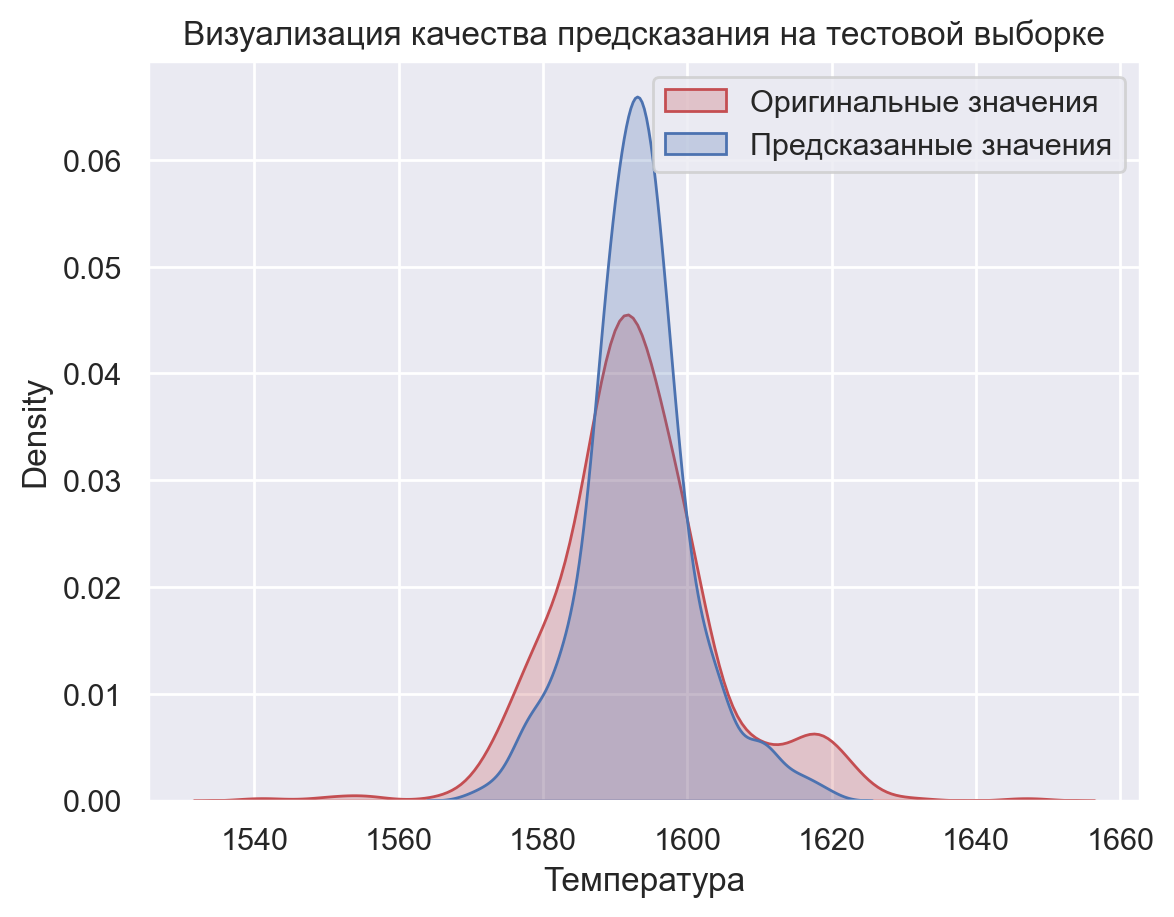
</div>


## Анализ важности признаков


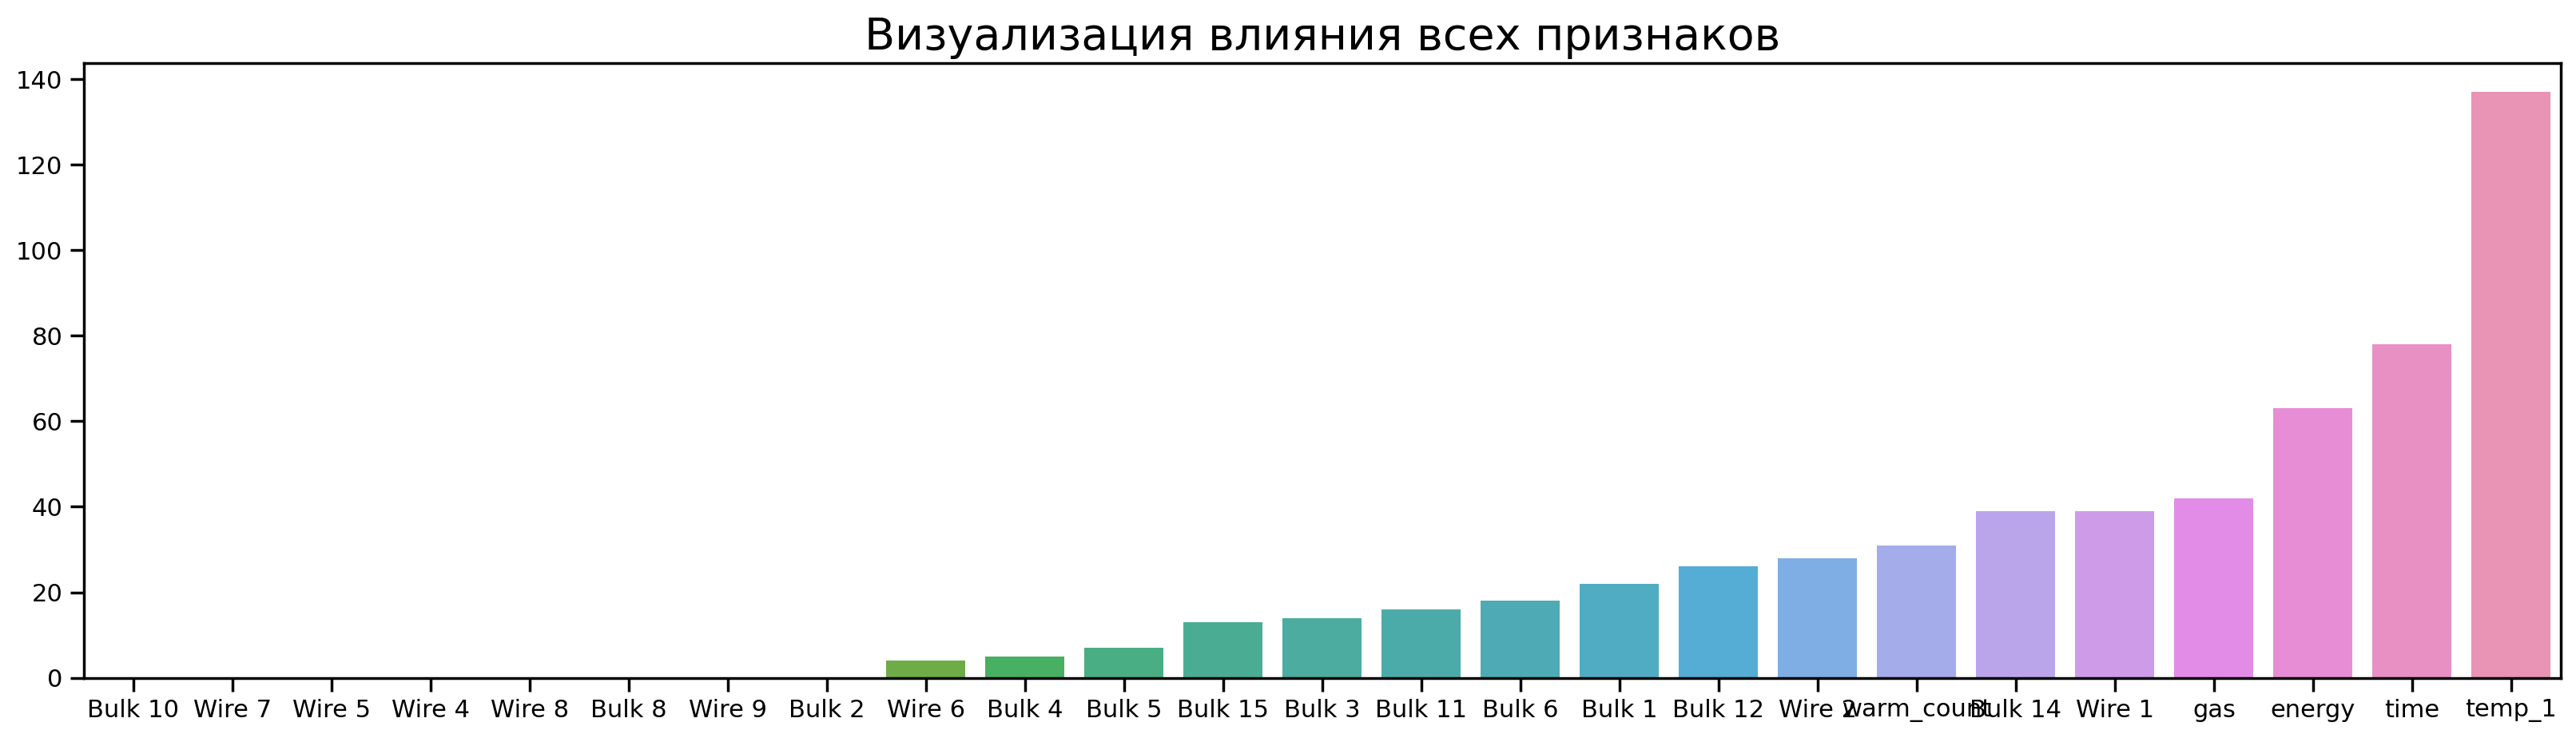

In [77]:
LGBM_best_params = grid_LGBM.best_params_
lgbm = LGBMRegressor(**LGBM_best_params)
lgbm.fit(features_train, target_train)
pred_test = lgbm.predict(features_test) 
sorted_idx = (np.argsort(lgbm.feature_importances_))

plt.subplots(figsize=(20,5))
sns.barplot(features_test.columns.values[sorted_idx], lgbm.feature_importances_[sorted_idx])
plt.title('Визуализация влияния всех признаков', fontsize=20);


In [78]:
top5 = pd.DataFrame(features_test.columns.values[sorted_idx], lgbm.feature_importances_[sorted_idx])

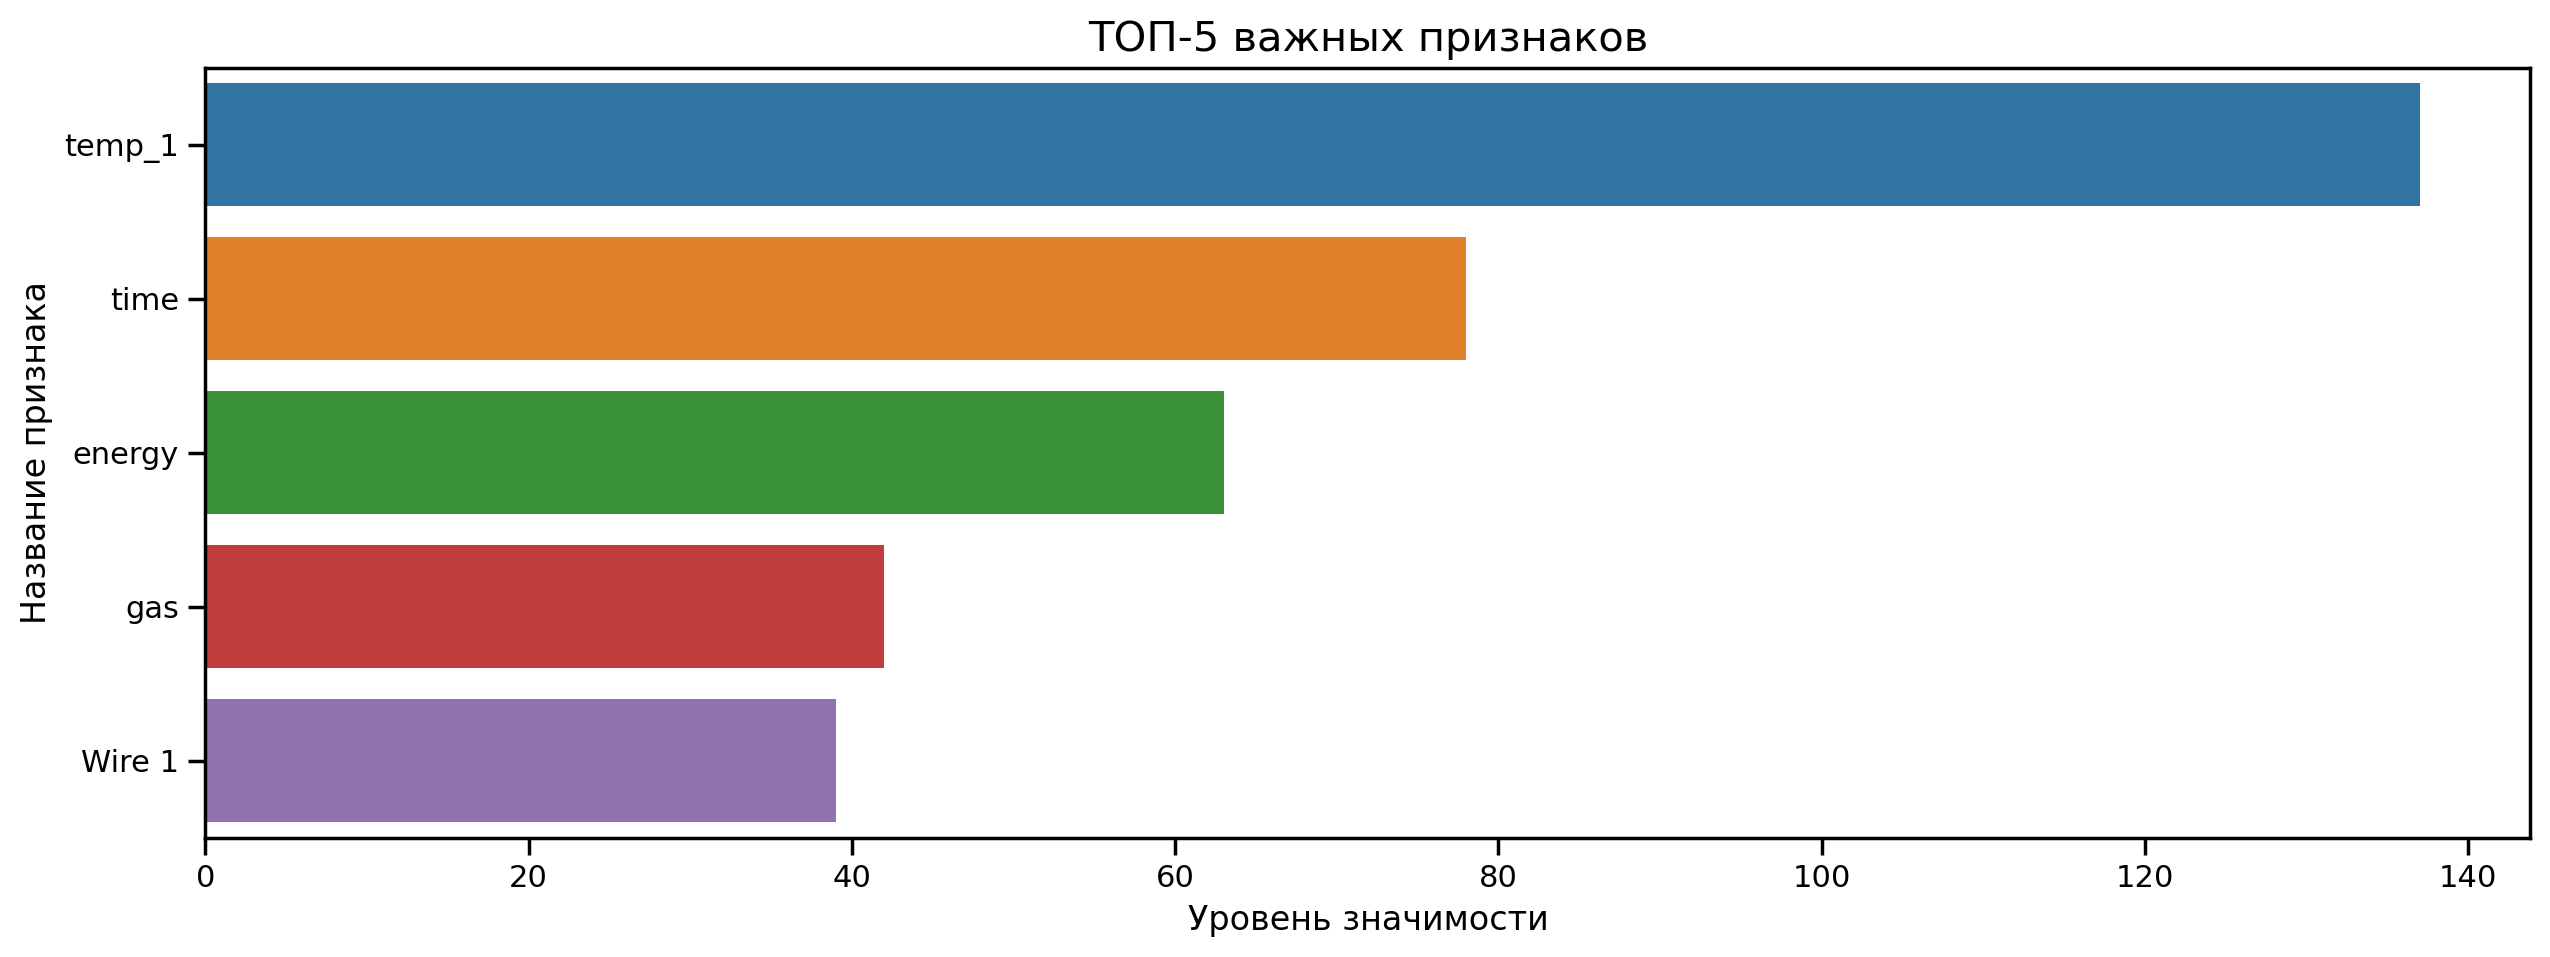

In [80]:
top5_sort = top5.sort_index(ascending=False).head()
plt.figure(figsize=(15,5))
sns.barplot(x=top5_sort.index,y=top5_sort[0]);
plt.title('ТОП-5 важных признаков', fontsize=15);
plt.xlabel('Уровень значимости');
plt.ylabel('Название признака');

**Топ-5 важных признаков**

- Начальная температура
- Время нагрева (сформированный признак)
- Энергия (сформированный признак)
- Газ
- Первые данные о проволочных материалах

Из 25 признаков — 8 не влияют на результат предсказания модели. Из 5 наиболее влиятельных признаков — 2, которые мы создали дополнительно, ранее их не было в датасете

**Цель проекта достигнута:** построили модель предсказания температуры стали, которая имеет среднюю абсолютную ошибку (MAE) не больше 6.8 — итоговая метрика MAE на тестовой выборке **достигла 6.04 градусов.**